Bambi is the project I dedicate the vast majority of my open-source development time. My goal is to make it a little better every time I push to the main branch. Lately I've been working to expand the class of models that Bambi supports. Until now, Bambi supported Generalized Linear Mixed Models (GLMMs). After the latest changes[^latest_changes] Bambi supports a wider class known as Generalized Linear Mixed Models for Location, Scale, and Shape. I also like the terminology used in [brms](https://mc-stan.org/users/interfaces/brms), Distributional Models.

The new additions to the library allow us to work with more flexible custom model families in an easier way. The question is: How to create a custom family in Bambi?

🚨 You don't have time or simply don't want to read the whole thing? Here's your [TL;DR](#tl-dr)

## Imports

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from bambi.plots import plot_cap
from matplotlib.lines import Line2D
from scipy.special import expit

## The Zero-Inflated Poisson distribution

I'm going to use the Zero-Inflated Poisson distribution to demonstrate how to add a custom family in Bambi. This distribution applies to random variables that show an excess of zeros  when describing the number of events that occur in a certain space or time period. 

Quoting Wikipedia [^zip_wikipedia] _"The zero-inflated Poisson (ZIP) model mixes two zero generating processes. The first process generates zeros. The second process is governed by a Poisson distribution that generates counts, some of which may be zero"._ The result is a mixture distribution that can be described as follows:


$$
\begin{array}{ll}
P(Y = 0) = (1 - \psi) + \psi e^{-\mu} \\
P(Y = y_i) = \displaystyle \psi \frac{e^{-\mu}\mu^y_i}{y_i!} & \text{with } y_i=1,2,3,\ldots
\end{array}
$$

Where 

* $y_i$ is the outcome, $y_i \in \mathbb{Z}^+$
* $\mu$ is the mean of the Poisson process, $\mu \ge 0$ 
* $\psi$ is the probability of the Poisson process, $0 < \psi < 1$

The mean is $\psi\mu$ and the variance is $\displaystyle \mu + \frac{1-\psi}{\psi}\mu^2$.

## The ZIP Regression model

We have a response variable $Y$, which represents the number of events that occur in a certain space or time period, and $p$ predictors $X_1, \cdots, X_p$. In the most general formulation of the model we consider, a function of the parameters in the response distribution is given by a linear combination of the predictors.

$$
\begin{aligned}
Y_i &\sim \text{ZIPoisson}(\mu_i, \psi_i) \\ 
g(\mu_i) &= \beta_0 + \beta_1 X_{1i} + ... + \beta_p X_{pi}\\
h(\psi_i) &= \alpha_0 + \alpha_1 X_{1i} + ... + \alpha_p X_{pi}
\end{aligned}
$$

* $g$ is the link function for the $\mu$ parameter
* $h$ is the link function for the $\psi$ parameter

It's possible to see this model written as 

$$
\begin{aligned}
Y_i &\sim \text{ZIPoisson}(\mu_i, \psi_i) \\ 
\mu_i &= g^{-1}(\beta_0 + \beta_1 X_{1i} + ...) \\
\psi_i &= h^{-1}(\alpha_0 + \alpha_1 X_{1i} + ...)
\end{aligned}
$$

where the requirement that $g$ and $h$ are both invertible becomes evident.

## Create the `ZeroInflatedPoisson` Family

It comes one of the most important parts of the blogpost. If you care about creating new model families, this is what you need. Spoiler: it's very easy.

To create a model family, we first need to understand _what is_ a family. A family is an entity that is defined by the combination of two objects

* A **likelihood** function -- the probability distribution for the response variable
* A **link** function for the parameters of the likelihood function.

Each of these three objects have their own class in Bambi. Families are created with the `Family` class, likelihood functions are created with the `Likelihood` class, and for link functions, well, we have `Link`.

### Create the likelihood

Let's get started with the likelihood function. Here we need:

* The name of the likelihood, which must be a valid PyMC distribution [^custom_likelihoods]
* The names of the parameters in the PyMC distribution
* The identification of a _parent_ or _main_ parameter. In regression settings this is usually the mean

In our case, we want to use the ZeroInflatedPoisson distribution from PyMC, which has parameters `mu` and `psi`, and `mu` is the parent parameter.

```python
likelihood = bmb.Likelihood("ZeroInflatedPoisson", params=["mu", "psi"], parent="mu")
```

That's it! We have our custom likelihood function.

### Create the link

Before telling Bambi which link functions we want for the parameters, we need to choose them. I'm going to use the logarithm function for $\mu$ and the logit function for $\psi$. In the original formulation of the model we replace $g$ with $\text{log}$ and $h$ with $\text{logit}$.

$$
\begin{aligned}
Y_i &\sim \text{ZIPoisson}(\mu_i, \psi_i) \\ 
\text{log}(\mu_i) &= \beta_0 + \beta_1 X_{1i} + ... + \beta_p X_{pi} \\
\text{logit}(\psi_i) &= \alpha_0 + \alpha_1 X_{1i} + ... + \alpha_p X_{pi}
\end{aligned}
$$


Next, we define them in code. Here we could use `bmb.Link`, but it's not needed in our case because both the $\text{log}$ and $\text{logit}$ link functions are already implemented in Bambi. We just need to pass their names and Bambi will know how to handle it [^custom_links]. We create a dictionary where the keys are the names of the parameters and the values are the link functions.

```python
links = {"mu": "log", "psi": "logit"}
```

### Create the family

Finally we can put the pieces together to create the family. Here we have all the code again so we see how simple it is. Notice we need to give the family a name. We can pass whatever we want here.

In [2]:
likelihood = bmb.Likelihood("ZeroInflatedPoisson", params=["mu", "psi"], parent="mu")
links = {"mu": "log", "psi": "logit"}
zip_family = bmb.Family("zip", likelihood, links)
zip_family

Family: zip
Likelihood: Likelihood(  
  name: ZeroInflatedPoisson,
  params: ['mu', 'psi'],
  parent: mu
)
Link: {'mu': Link(  
  name: log,
  link: <ufunc 'log'>,
  linkinv: <ufunc 'exp'>
), 'psi': Link(  
  name: logit,
  link: <function logit at 0x7f2fecbb7880>,
  linkinv: <function expit at 0x7f2fecbb77f0>
)}

When we print the family we get information about the name, the likelihood, and the links. It contains many details for the link functions, but they're not important now [^check_links_docs].

Now that we have our brand new custom family, it's time to test it!

## The simplest case

We need some data to use our new family. How can we get it? Simulation!

Here we consider the case where we obtain samples from **a single ZIPoisson distribution**. There are no predictors that allow us to distinguish observations. Both $\mu$ and $\psi$ are the same for all observations.

$$
\begin{aligned}
Y_i &\sim \text{ZIPoisson}(\mu, \psi) \\ 
\mu &\sim \text{Some prior} \\
\psi &\sim \text{Some prior}
\end{aligned}
$$

### Simulate the data

To simulate draws from this ZIPoisson distribution we can use plain NumPy in a very a manual way, simply concatenate a bunch of zeros to an array with draws from a Poisson distribution and we're done.

In [3]:
rng = np.random.default_rng(121195)
x = np.concatenate([np.zeros(250), rng.poisson(lam=3, size=750)])
df = pd.DataFrame({"response": x})

Let's explore the data now. A simple barchart is enough to get the information we need.

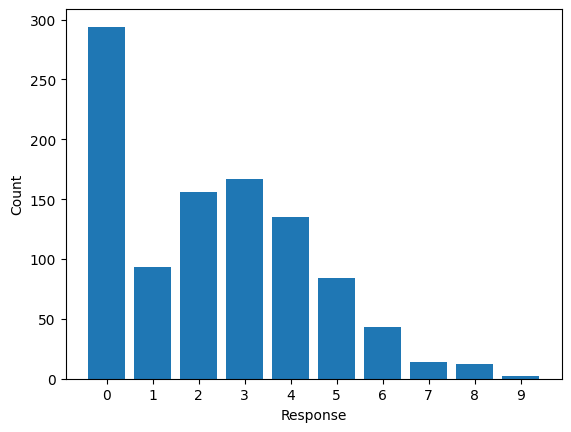

In [4]:
#| echo: false
values, counts = np.unique(x, return_counts=True)
fig, ax = plt.subplots()
ax.bar(values, counts)
ax.set(xlabel="Response", ylabel="Count", xticks=values);

Definetely, it looks like a Poisson distribution but the bar at zero is unusually high, indicating excess of zeros or zero-inflation.

### Build and fit the model

Without much preamble we're going to build the model. In this basic model we don't have predictors for any of the parameters. This means we specify an intercept-only model for $\mu$, and a prior distribution for $\psi$. Here I use a Beta distribution that guarantees the values of $\psi$ are bounded between 0 and 1.

In [5]:
priors = {"psi": bmb.Prior("Beta", alpha=3, beta=3)}
model = bmb.Model("response ~ 1", df, family=zip_family, priors=priors)
model

       Formula: response ~ 1
        Family: zip
          Link: mu = log
  Observations: 1000
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        
        Auxiliary parameters
            response_psi ~ Beta(alpha: 3.0, beta: 3.0)

And now... let's get the sampler running!

In [6]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [response_psi, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


It worked fast, without warnings or errors, I would say that's a great start. The next question is: does the fit make sense? I'm not going to investigate it thoroughly now. A visualization of the posterior predictive distribution will be enough.

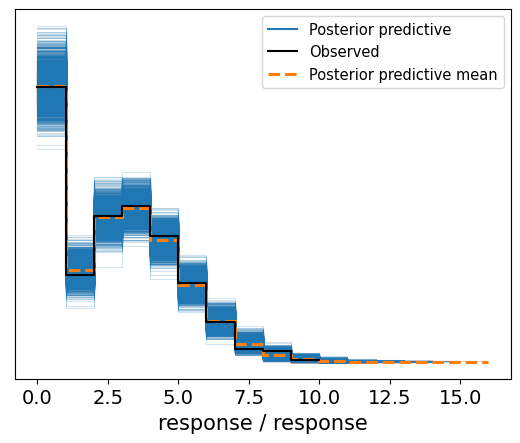

In [7]:
model.predict(idata, kind="pps") # get draws from the posterior predictive distribution
az.plot_ppc(idata);

Awesome! Feels like magic. We created a custom family and it just... worked. 

## A second example, now with a predictor

Let's keep testing our `zip` family. Now we're going to simulate data again. This time we have a numerical predictor that is related with both $\mu$ and $\psi$. 

The model is

$$
\begin{aligned}
Y_i &\sim \text{ZIPoisson}(\mu_i, \psi_i) \\ 
\text{log}(\mu_i) &= \beta_0 + \beta_1 X_{1i} \\
\text{logit}(\psi_i) &= \alpha_0 + \alpha_1 X_{1i}
\end{aligned}
$$

but we first need the data...

### Simulate the data

This time we use NumPy to generate random values for the predictor, but we use `pm.draw()` to get draws from a `ZeroInflatedPoisson` distribution. 

In [8]:
rng = np.random.default_rng(121195)
x = np.sort(rng.uniform(0.2, 3, size=1000))

b0, b1 = 0.2, 0.9
a0, a1 = 2.5, -0.7
mu = np.exp(b0 + b1 * x)
psi = expit(a0 + a1 * x)

y = pm.draw(pm.ZeroInflatedPoisson.dist(mu=mu, psi=psi))
df = pd.DataFrame({"y": y, "x": x})

Visualizations are the key to understand how the predictor is associated with the parameters of the likelihood.

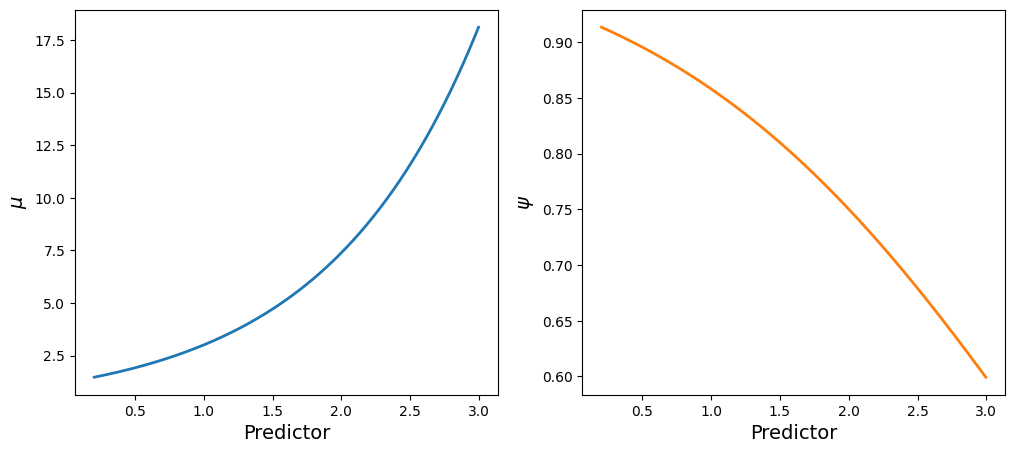

In [9]:
#| echo: false
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(x, mu, lw=2)
axes[1].plot(x, psi, lw=2, color="C1")

axes[0].set_xlabel("Predictor", size=14)
axes[1].set_xlabel("Predictor", size=14)
axes[0].set_ylabel("$\\mu$", size=14)
axes[1].set_ylabel("$\\psi$", size=14);

Here we have two main takeaways

* The mean of the Poisson process increases with the value of the predictor
* The importance of the Poisson process in the mixture decreases with the value of the predictor

Finally, why not displaying the observations in a scatterplot of the predictor versus the response. 

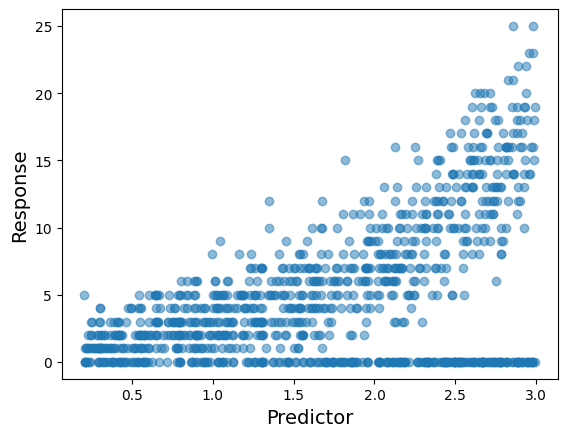

In [10]:
#| echo: false
fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.5);
ax.set_xlabel("Predictor", size=14)
ax.set_ylabel("Response", size=14);

See how the response values tend to increase as the predictor is larger, but also it tends to be more observations with a zero count.

### Build and fit the model (again)

It's time to define the new model. Since we model both $\mu$ and $\psi$ components as a function of the predictor, they both need a model formula. This is when we use `bmb.Formula()`. The first formula is the one for the `parent` parameter, which is $\mu$, and the following formulas are for the non-parent parameters. In this case, we only have $\psi$. Finally notice we don't need to create the family again, we just reuse it. 

In [11]:
formula = bmb.Formula("y ~ x", "psi ~ x")
model = bmb.Model(formula, df, family=zip_family)
model

       Formula: y ~ x
                psi ~ x
        Family: zip
          Link: mu = log
                psi = logit
  Observations: 1000
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.7176)
            x ~ Normal(mu: 0.0, sigma: 3.0682)
    target = psi
        Common-level effects
            psi_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            psi_x ~ Normal(mu: 0.0, sigma: 1.0)

The model summary contains so much information. It shows the priors for the parameters in the linear predictors of both parameters in different sections. First we have the priors for `mu` below `target = mu`, and then the priors for `psi` below `target = psi`.

It's also helpful to show a graph representation of the model.

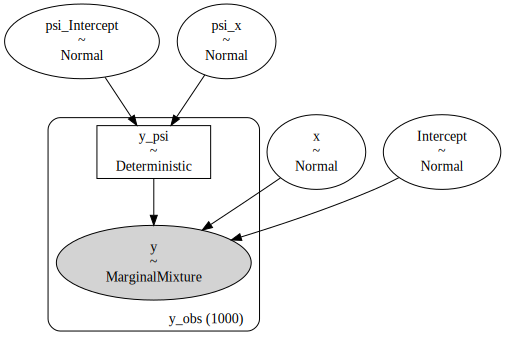

In [12]:
model.build()
model.graph()

Model fitting is the same way as always.

In [13]:
idata = model.fit(random_seed=121195)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, x, psi_Intercept, psi_x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


### Evaluate the inference

Because it's a simulated scenario, we know the true parameter values. This allows us to verify if the posteriors are recovering them.

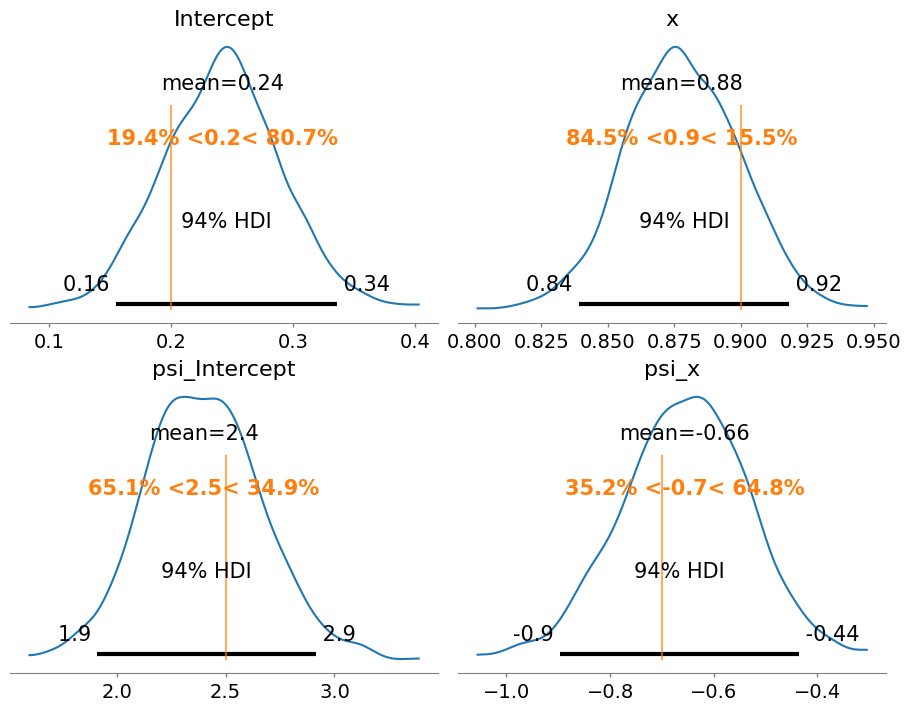

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(9, 7), layout="constrained")
az.plot_posterior(
    idata,
    var_names=["Intercept", "x", "psi_Intercept", "psi_x"], 
    ref_val=[b0, b1, a0, a1],
    ax=axes
);

Great news! The true values are contained with the 94% HDIs, meaning the model and the inference process is able to recover true parameter values.

### Show-off Bambi a little more

Before concluding I would like to show-off another function I've been working recently, `plot_cap()`. This function allows us to see how a model parameter evolves as we change values of one or more predictors. It's so flexible we can get plots for both $\mu$ and $\psi$.

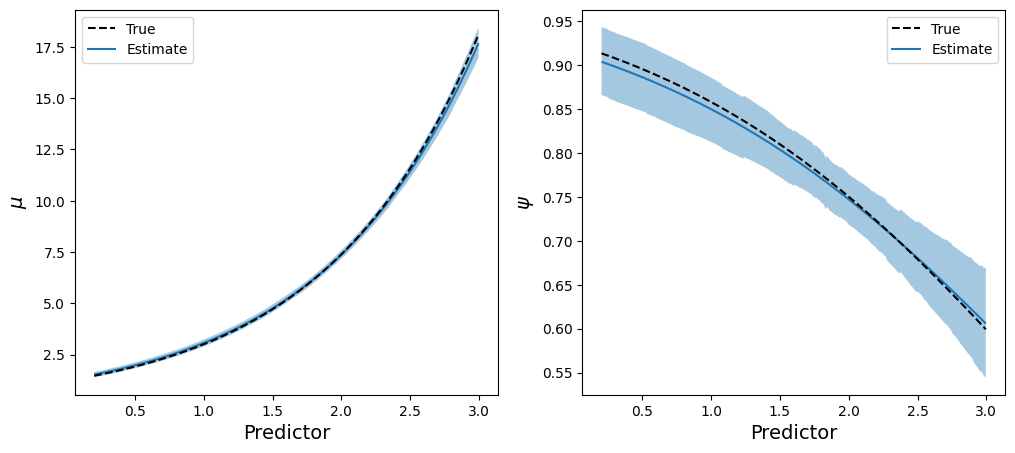

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_cap(model, idata, "x", ax=axes[0]) # By default it plots the "parent" parameter
plot_cap(model, idata, "x", target="psi", ax=axes[1])

axes[0].plot(x, mu, color="black", ls="--")
axes[1].plot(x, psi, color="black", ls="--")

axes[0].set_xlabel("Predictor", size=14)
axes[1].set_xlabel("Predictor", size=14)
axes[0].set_ylabel("$\\mu$", size=14)
axes[1].set_ylabel("$\\psi$", size=14)


handles = [Line2D([], [], color="black", ls="--"), Line2D([], [], color="C0")]
labels = ("True", "Estimate")
axes[0].legend(handles, labels, loc="upper left")
axes[1].legend(handles, labels, loc="upper right");

Notice the majority of the code handles Matplotlib specific details. To get the estimated lines and the credible bands we used the same one-liner twice, `plot_cap()`, and it did the magic for us. 

Leaving that parise aside, this is a different way to see the model is recovering parameters very well. We can compare the estimated curves for both parameters with the real ones, and see they're so close.

## Conclusion

We work a lot to make Bambi as flexible as possible, without asking users to do too much on their end. I think custom families is a subject where all the work starts to pay off. In this blogpost we were able to define a custom family in just three lines of code (!). What's more, we got so many things for free in exchange for our effort. To mention a few

* Compute the posterior distribution of parameters of the response distribution
    * This works for both in-sample and out-of-sample data
* Compute the posterior predictive distribution
    * Also works for in-sample or out-of-sample data
* Out of the box visualizations to evaluate model fit
* No need to write any PyMC code or low-level code

I hope you found this writeup useful and needless to say I'm happy to collect feedback, suggestions, and questions.

## TL;DR {#tl-dr}

If you want a custom family you need to

* Create a Likelihood instance
* Define link functions
* Use them to instantiate a Family object

```python
likelihood = bmb.Likelihood("ZeroInflatedPoisson", params=["mu", "psi"], parent="mu")
links = {"mu": "log", "psi": "logit"}
zip_family = bmb.Family("zero-inflated-poisson", likelihood, links)
```

[^latest_changes]: See the PR [#607](https://github.com/bambinos/bambi/pull/607)  
[^zip_wikipedia]: [https://en.wikipedia.org/wiki/Zero-inflated_model#Zero-inflated_Poisson](https://en.wikipedia.org/wiki/Zero-inflated_model#Zero-inflated_Poisson)  
[^custom_likelihoods]: Custom likelihood functions are also possible but we don't cover them here  
[^custom_links]: It's possible to create custom link functions with `bmb.Link` as well  
[^check_links_docs]: If you're curious, check the docs. If you're awesome, provide feedback 😄